<a href="https://colab.research.google.com/github/taliafabs/STA496/blob/main/MidtermPaper/code/ModelDiagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA496 Midterm Paper Model Diagnostics

This notebook shows Bayesian Posterior Analysis and Markov Chain Monte Carlo (MCMC) diagnostics for Model 0, which was used throughout this project to estimate voting behavior.

Resources used:
* https://www.pymc.io/welcome.html
* https://www.arviz.org/en/latest/
* https://medium.com/@mail2rajivgopinath/bayesian-mmm-diagnostics-analysis-and-comparison-6a34e727c543

**Model 0 (full model)**
\begin{align*}
p(\text{vote\_trump} = 1) &= \sigma\big(
  \beta_0
  + \beta_1 \cdot \text{age\_bracket}
  + \beta_2 \cdot \text{gender}
  + \beta_3 \cdot \text{educ}
  + \beta_4 \cdot \text{state}
  + \beta_5 \cdot \text{region}
  + \beta_6 \cdot \text{urbancity}
  + \beta_7 \cdot \text{biden\_approval}
  + \beta_8 \cdot \text{econ\_past\_year}
  + \beta_9 \cdot \text{price\_change\_past\_year}
  + \beta_{10} \cdot \text{family\_income\_past\_year}
  + \beta_{11} \cdot (\text{race} \times \text{region})
  + \beta_{12} \cdot (\text{race} \times \text{urbancity})
  + \beta_{13} \cdot (\text{race} \times \text{educ})
  + \beta_{14} \cdot (\text{race} \times \text{gender})
\big)
\end{align*}



In [ ]:
# Workplace setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pymc as pm
import arviz as az
import random
from scipy import stats
from scipy.stats.distributions import chi2

## Data

### Load data

In [ ]:
# ces 2024
# url = "https://raw.githubusercontent.com/taliafabs/STA496/f2606bb9f82da6cc538e5f02998c73ee75dd13c7/MidtermPaper/data/ces24_analysis_data.parquet"
url = "https://github.com/taliafabs/STA496/raw/main/MidtermPaper/data/ces24_analysis_data.parquet"
ces24_df = pd.read_parquet(url, engine="pyarrow")

# split race into Black, white, hispanic, and other
# same approach as kuriwaki et al
# ces24_df['race'].value_counts()
race_map = {
    'White': 'White',
    'Black': 'Black',
    'Hispanic': 'Hispanic',
    'Asian': 'All Other Races',
    'Two or more races': 'All Other Races',
    'Other': 'All Other Races',
    'Native American': 'All Other Races',
    'Middle Eastern': 'All Other Races'
}
ces24_df['race'] = ces24_df['race'].map(race_map)
ces24_df['race'] = pd.Categorical(ces24_df['race'])

In [ ]:
ces24_df = ces24_df[(ces24_df['gender'] == "Woman") | (ces24_df['gender'] == "Man")]

In [ ]:
ces24_df.head()

,vote_trump,presvote24,race,age_bracket,birthyr,hispanic,gender,educ,state,region,urbancity,econ_past_year,family_income_past_year,price_change_past_year,biden_approval,tookpost,commonweight,commonpostweight
0,0,Kamala Harris (D),Black,45–54,1978,No,Woman,High school graduate,Pennsylvania,Northeast,City,Stayed about the same,Stayed about the same,Stayed about the same,Strongly approve,Yes,0.418897,0.180057
1,0,Kamala Harris (D),Hispanic,55–64,1968,Yes,Man,4-year,New York,Northeast,City,Gotten much better,Stayed about the same,Increased somewhat,Strongly approve,Yes,0.946650,0.700897
2,0,Kamala Harris (D),White,75+,1946,No,Woman,2-year,Pennsylvania,Northeast,Suburb,Gotten much better,Stayed about the same,Decreased somewhat,Strongly approve,Yes,0.194303,0.046275
3,0,Kamala Harris (D),White,18–24,2001,Yes,Woman,High school graduate,California,West,Suburb,Gotten much worse,Stayed about the same,Increased a lot,Strongly disapprove,Yes,0.083223,0.008897
4,0,Other,White,65–74,1955,No,Woman,High school graduate,Montana,West,Town,Gotten much worse,Stayed about the same,Increased a lot,Somewhat disapprove,Yes,0.596598,0.555395


In [ ]:
# 2024 election results
results24_url = "https://raw.githubusercontent.com/taliafabs/STA496/c081804df5e98000c7e74493087f3d4b8b39db2b/MidtermPaper/data/pres24_results_data.parquet"
results24_df = pd.read_parquet(results24_url, engine="pyarrow")

In [ ]:
results24_df.head()

,state,state_abbrev,candidate_name,ballot_party,votes,percent,winner
710,Alabama,AL,Donald Trump,REP,1462616.0,64.572092,True
711,Alabama,AL,Kamala Harris,DEM,772412.0,34.100720,False
732,Alaska,AK,Donald Trump,REP,184458.0,54.544809,True
733,Alaska,AK,Kamala Harris,DEM,140026.0,41.406128,False
522,Arizona,AZ,Donald Trump,REP,1770242.0,52.217048,True


### Preprocess the 2024 CES data

In [ ]:
# make a binary df that only includes harris and trump voters for logistic modeling
train_df = ces24_df.sample(frac=0.75, random_state=42)
test_df = ces24_df.drop(train_df.index)

### Variables and helper functions

In [ ]:
# colors
dem_blue = "#083A90"
gop_red = "#E9141D"
other = 'darkgray'

In [ ]:
# stacked bar plot using matplotlib
def plot_stacked_bar(pct_df, figsize=(8, 4), label_fontsize=10, tick_fontsize=8,
                     legend_fontsize=9, title='', legend_position = (0.5, -0.07),
                     legend_ncol=3):
    """
    Plots a stacked bar visualization to show trump and harris percentages.
    Input:
      - pct_dataframe: pandas dataframe with trump and harris percentages
    Output:
      - stacked bar plot
    """
    # Define colors as a dictionary within the function
    colors = {
        'Donald Trump (R)': "#E9141D", # gop_red
        'Kamala Harris (D)': "#083A90", # dem_blue
        'Other': 'darkgray' # other
    }

    new_plot = pct_df.plot(
        kind='barh',
        stacked=True,
        color=[colors[col] for col in pct_df.columns],
        figsize=figsize
    )
    new_plot.set_xticks([])

    for i, (index, row) in enumerate(pct_df.iterrows()):
        cum_width = 0
        for col in pct_df.columns:
            value = row[col]
            new_plot.text(
                cum_width + value / 2,  # center of the bar segment
                i,                      # bar index
                f'{value:.1f}%',        # label text
                va='center',
                ha='center',
                color='white',
                fontsize=6,
                fontweight='bold'
            )
            cum_width += value

    plt.axvline(x=50, color='#de89ff', linestyle='--', linewidth=1.2)

    # Add label for the 50% line
    ymax = len(pct_df) - 0.5
    plt.text(50, -0.65, '50%', color='#de89ff', fontsize=label_fontsize, va='bottom', fontweight='bold')

    plt.legend(
        title='',                     # Optional: remove legend title
        loc='upper center',           # Center the legend horizontally
        bbox_to_anchor=legend_position, # Shift it below the axes
        borderaxespad=0.0,
        ncol=legend_ncol                       # Spread legend items across columns
    )
    plt.title(title, fontsize=12)
    plt.xlabel('')
    plt.show()

In [ ]:
# faceted bar plot using seaborn.sns
def sns_bar_plot():
  pass

In [ ]:
def create_dummy_interaction(col1, col2):
  result = pd.DataFrame()
  col1_dummies = pd.get_dummies(col1, drop_first=True)
  col2_dummies = pd.get_dummies(col2, drop_first=True)
  for col1_val in col1_dummies.columns:
    for col2_val in col2_dummies.columns:
      result[f'{col1_val}_{col2_val}'] = col1_dummies[col1_val] * col2_dummies[col2_val]
  return result

In [ ]:
# Create interaction terms
race_gender_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['gender'])
race_educ_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['educ'])
race_region_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['region'])
race_urban_interaction_terms = create_dummy_interaction(ces24_df['race'], ces24_df['urbancity'])

# ces24_binary = ces24_df[ces24_df['presvote24'] != 'Other']
ces24_dummies = pd.concat([
    pd.get_dummies(ces24_df, drop_first=True),
    race_gender_interaction_terms,
    race_educ_interaction_terms,
    race_region_interaction_terms,
    race_urban_interaction_terms,
], axis=1)

# make it binary (remove third party voters for modeling part)
ces24_dummies[ces24_dummies['presvote24_Other'] == 0]

# drop the presvote24 related columns
ces24_dummies = ces24_dummies.drop(columns=['presvote24_Other'])
ces24_dummies = ces24_dummies.drop(columns=['presvote24_Kamala Harris (D)'])
ces24_dummies = ces24_dummies.drop(columns=['birthyr'])


,vote_trump,commonweight,commonpostweight,race_Black,race_Hispanic,race_White,age_bracket_25–34,age_bracket_35–44,age_bracket_45–54,age_bracket_55–64,...,Black_Rural area,Black_Other,Hispanic_Suburb,Hispanic_Town,Hispanic_Rural area,Hispanic_Other,White_Suburb,White_Town,White_Rural area,White_Other
0,0,0.418897,0.180057,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0.946650,0.700897,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,0,0.194303,0.046275,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0,0.083223,0.008897,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0.596598,0.555395,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59993,0,0.834862,5.484041,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59995,1,0.255305,2.469711,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
59996,0,0.964466,0.931537,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
59997,0,0.246773,0.195502,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


## Bayesian Posterior Analysis and Markov Chain Monte Carlo (MCMC) Diagnostics



In [ ]:
X_ = ces24_dummies.drop(columns=['vote_trump', 'commonpostweight', 'commonweight'])
y_ = ces24_dummies['vote_trump']

In [ ]:
type(X_)

pandas.core.frame.DataFrame

In [ ]:
X_ = X_.astype('float64').to_numpy()
y_ = y_.astype('float64').to_numpy()

In [ ]:
X_.shape

(45636, 130)

In [ ]:
X_

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

resource used:
https://www.pymc.io/welcome.html
https://discourse.pymc.io/t/prior-choice-for-discrete-features-logistic-regression/11060


In [ ]:
with pm.Model() as BayesianModel0:
  # define priors
  w0 = pm.Normal('w0', mu=0, sigma=1)
  w = pm.Normal('weights', mu=0, sigma=1, shape = X_.shape[1])
  logits = pm.math.dot(X_, w) + w0
  p_hat = pm.math.sigmoid(logits)

  # define likelihood
  y_obs = pm.Bernoulli('y_obs', p=p_hat, observed=y_)

  # inference: make sure to have more than 1 chain for r hat
  idata0 = pm.sample(draws=1000, chains=4, tune=1000, return_inference_data=True)

Output()

/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (131) in plot_posterior, generating only 40 plots
  warnings.warn(


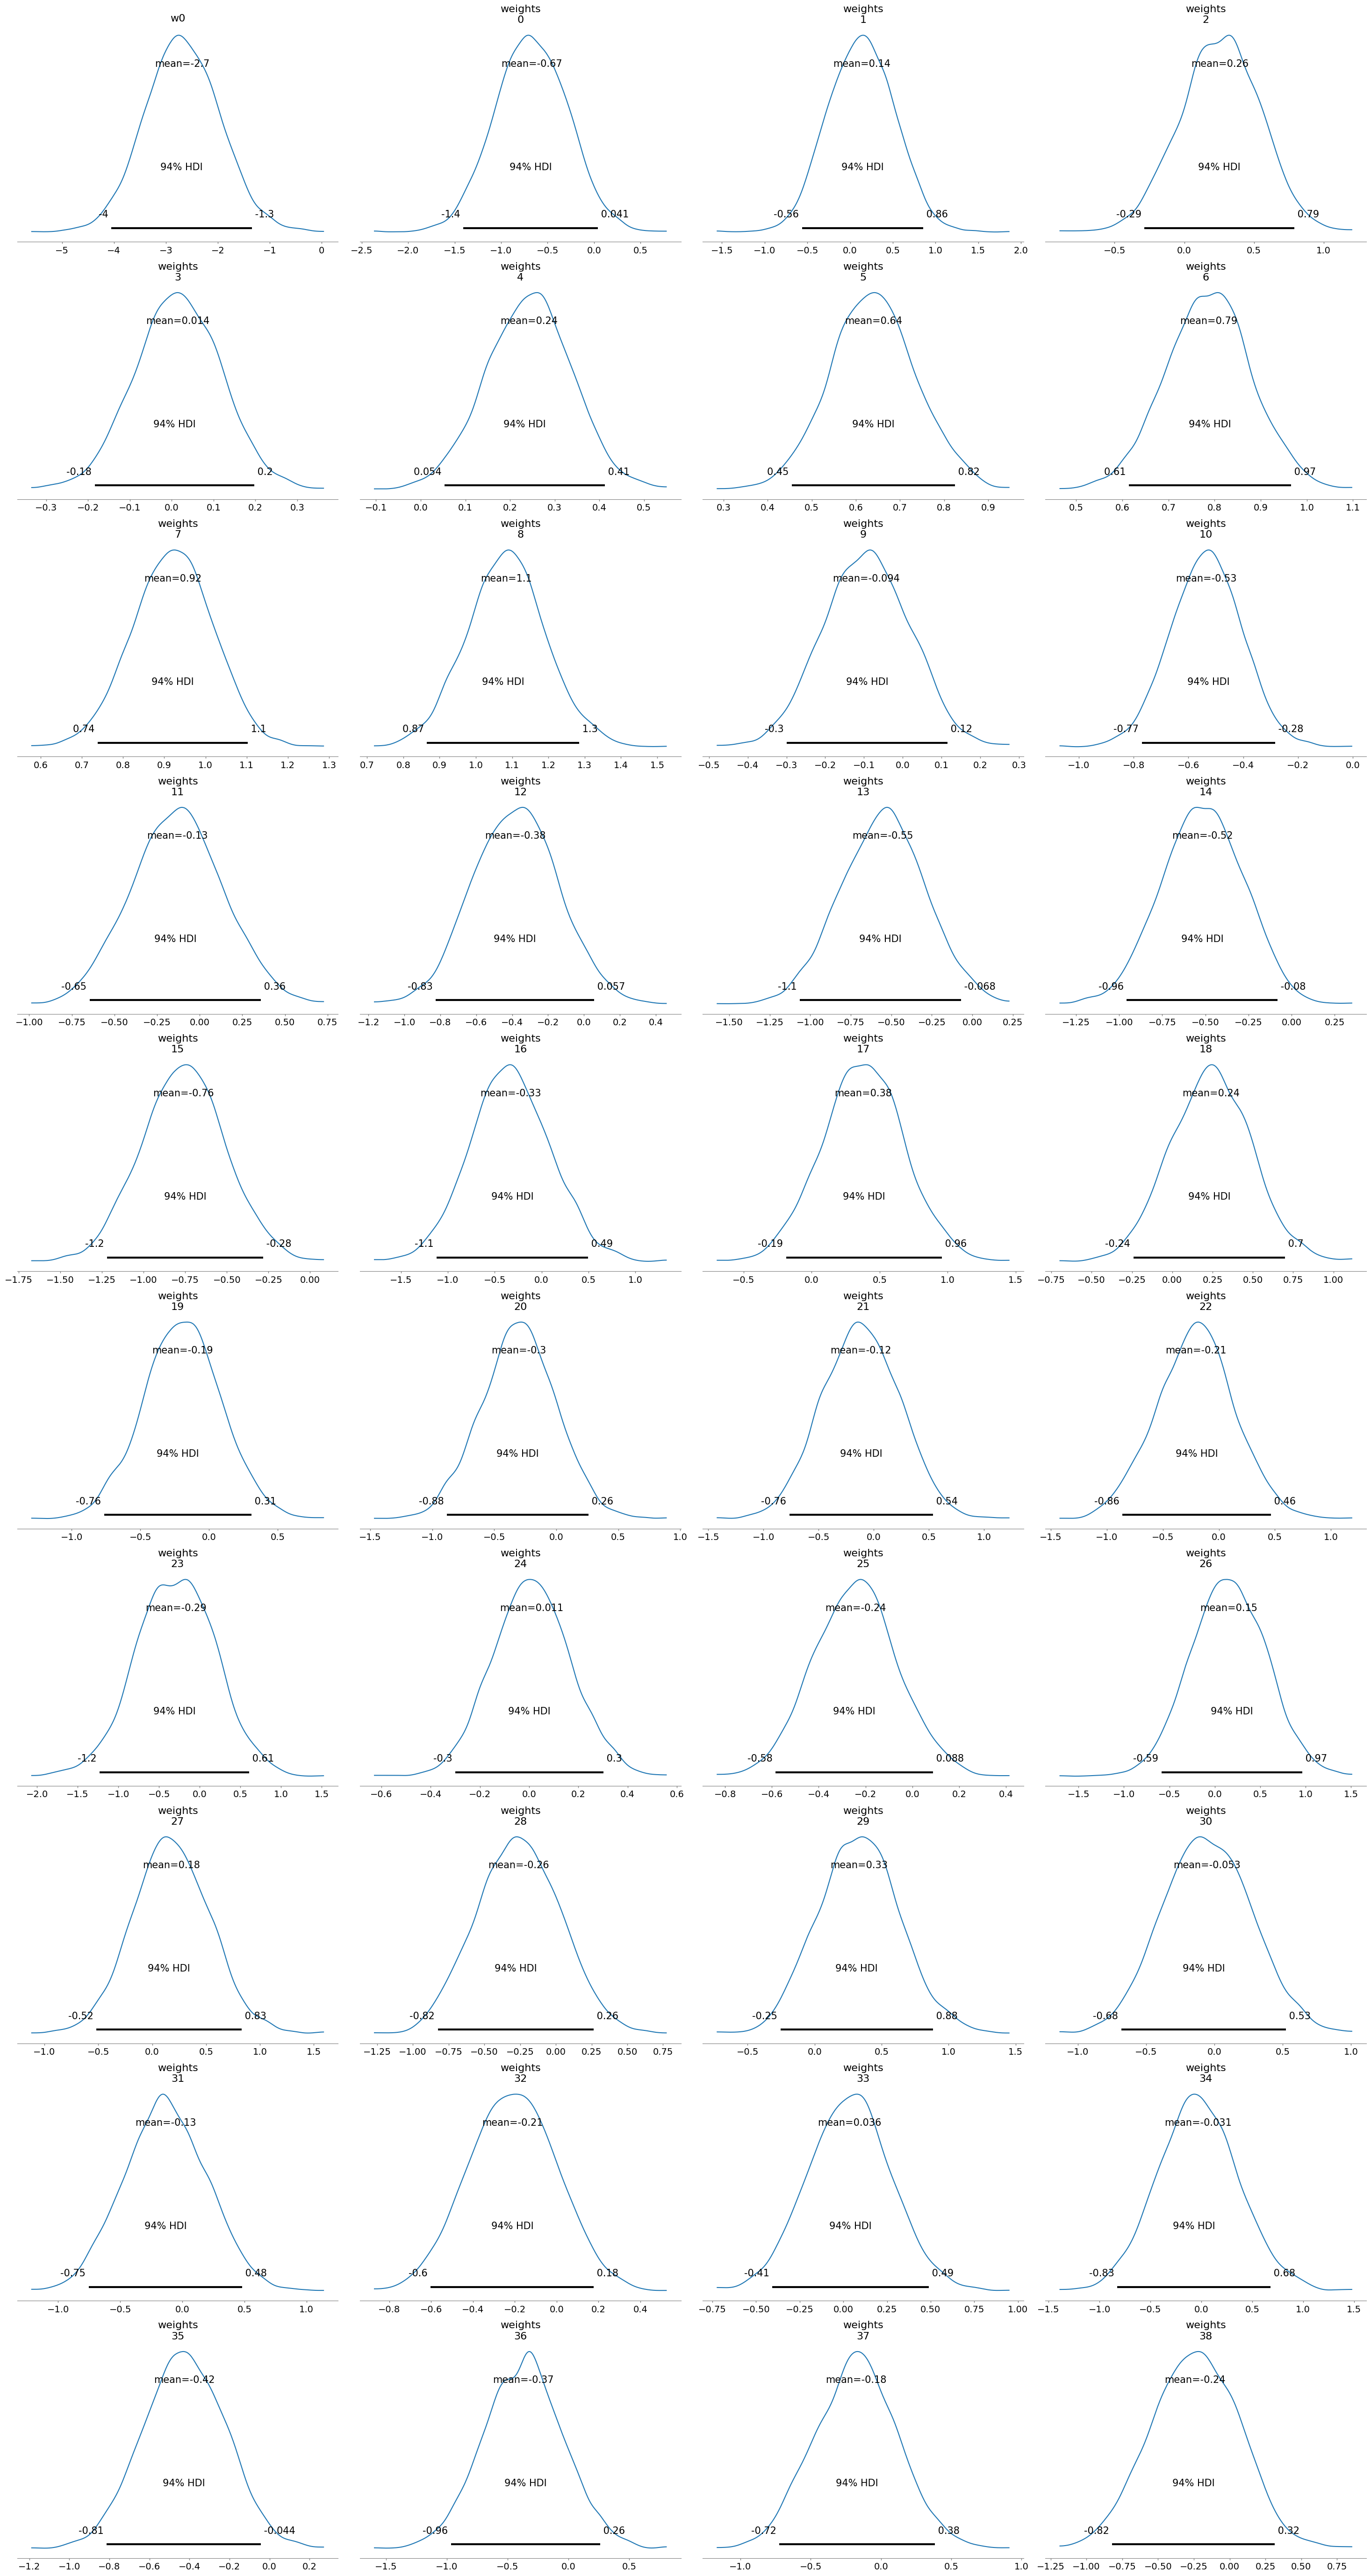

In [ ]:
# posterior plot
az.plot_posterior(idata0, var_names=['w0', 'weights'])
plt.tight_layout()
plt.show()

Output()

<Axes: xlabel='y_obs'>

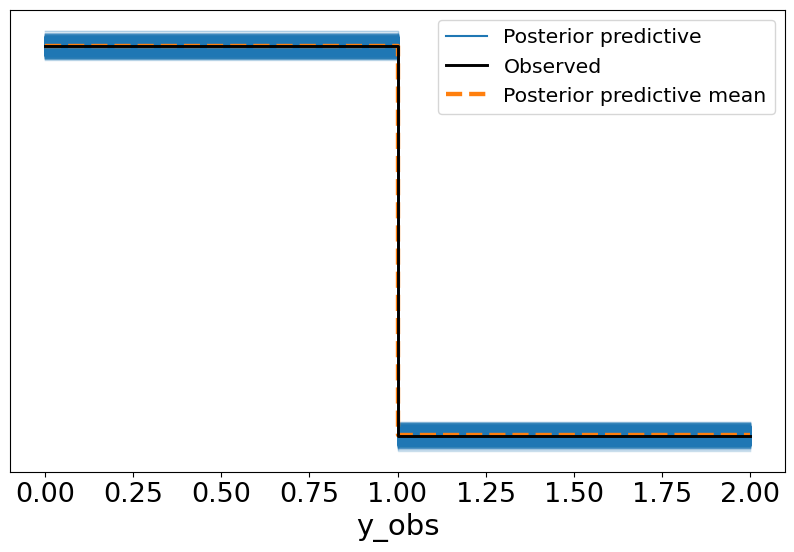

In [ ]:
# posterior predictive checks
with BayesianModel0:
  ppc = pm.sample_posterior_predictive(idata0)

# plot posterior predictive checks
az.plot_ppc(ppc, figsize=(10,6))

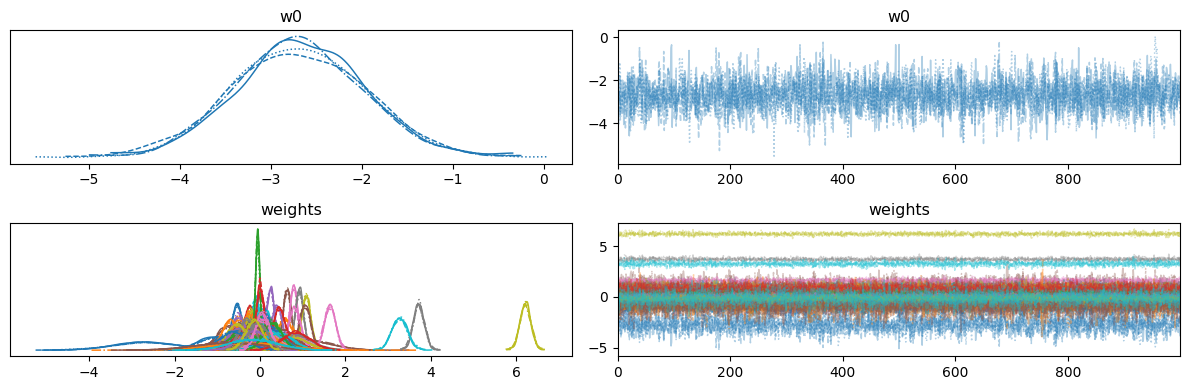

In [ ]:
# trace plots
az.plot_trace(idata0, var_names=['w0', 'weights'])
plt.tight_layout()
plt.show()

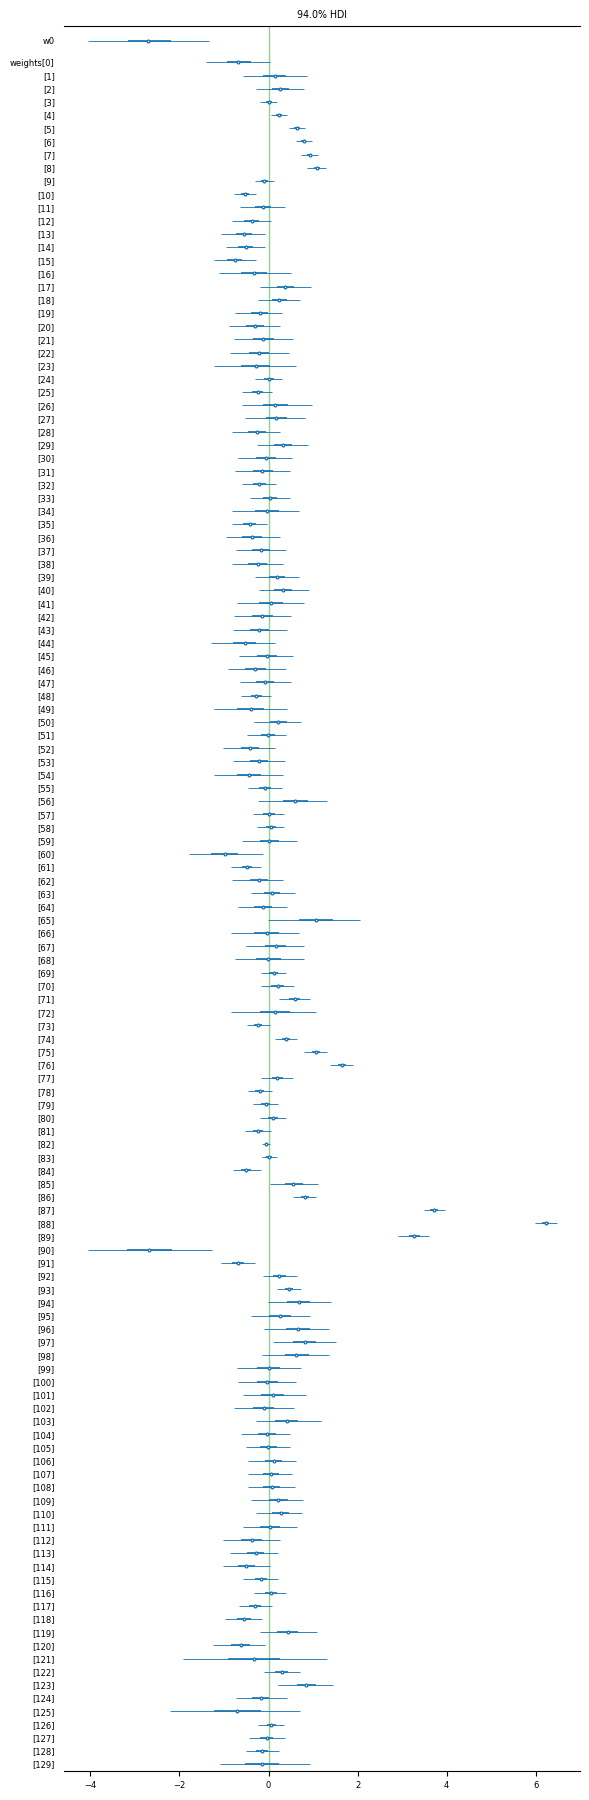

In [ ]:
# credible intervals
az.plot_forest(idata0, combined=True, rope = (0,0), textsize=6)
plt.tight_layout()
plt.show()

In [ ]:
# effective sample size
ess_ = az.ess(idata0)
print("Effective sample size (ESS):\n", ess_)

Effective sample size (ESS):
 <xarray.Dataset> Size: 2kB
Dimensions:        (weights_dim_0: 130)
Coordinates:
  * weights_dim_0  (weights_dim_0) int64 1kB 0 1 2 3 4 5 ... 125 126 127 128 129
Data variables:
    w0             float64 8B 3.004e+03
    weights        (weights_dim_0) float64 1kB 1.955e+03 1.972e+03 ... 3.22e+03


/tmp/ipython-input-1530185221.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


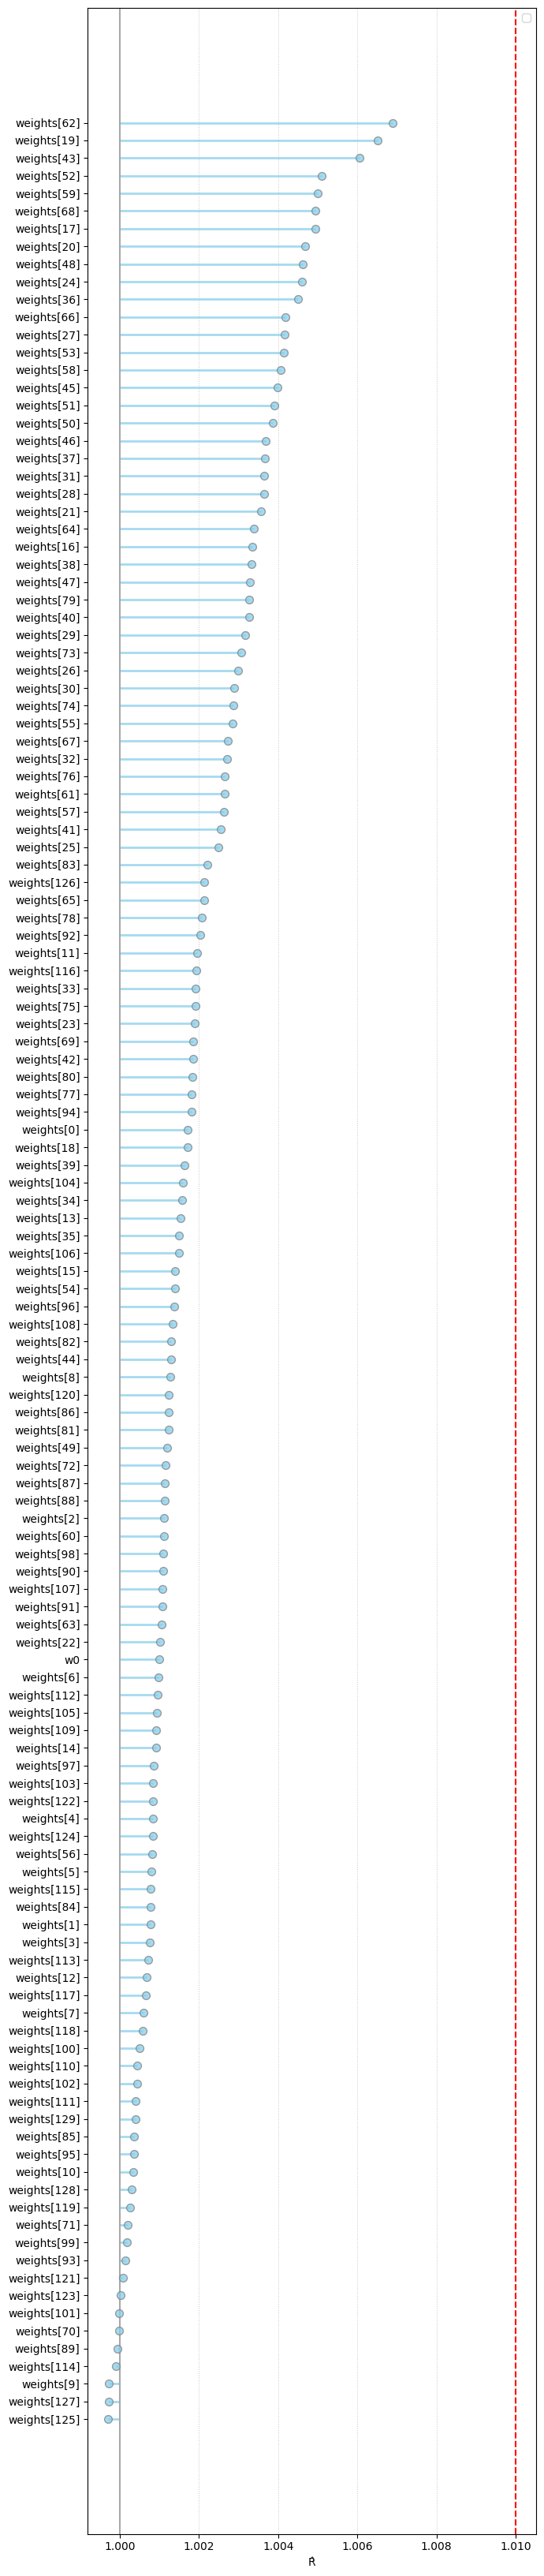

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# ChatGPT was used to plot this

# Compute R̂ values
rhat = az.rhat(idata0)

# Flatten variables and values for plotting
labels = []
values = []

for var in rhat.data_vars:
    vals = rhat[var].values.flatten()
    if vals.size == 1:
        labels.append(var)
        values.append(vals.item())
    else:
        for i, v in enumerate(vals):
            labels.append(f"{var}[{i}]")
            values.append(v)

values = np.array(values)
labels = np.array(labels)

# Sort by descending R̂ (highest on top)
sorted_idx = np.argsort(values)[::-1]
values_sorted = values[sorted_idx]
labels_sorted = labels[sorted_idx]

# Plot setup
plt.figure(figsize=(7, max(5, 0.25 * len(labels_sorted))))

# Y positions for dots
y_pos = np.arange(len(labels_sorted))

# Plot horizontal lines from 1 to R̂ value
for x, y in zip(values_sorted, y_pos):
    plt.hlines(y, 1, x, color='skyblue', alpha=0.75, linewidth=2)

# Plot blue dots at R̂ values
plt.scatter(values_sorted, y_pos, color='skyblue', alpha=0.75, edgecolors='gray', s=50, zorder=3)

# Reference line at R̂=1.01
plt.axvline(1.01, color='red', linestyle='--', zorder=2)
# label='R̂ = 1.01 threshold',
plt.axvline(1.00, color='darkgray')

# Y-axis labels (parameters)
plt.yticks(y_pos, labels_sorted)
plt.gca().invert_yaxis()

plt.xlabel('R̂')
# plt.title('R̂ Diagnostic with Distance from 1')
plt.grid(axis='x', linestyle=':', linewidth=0.7, alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()
